# Particle Flow Filter: Matrix-Valued Kernel Demonstration

## Overview

This notebook demonstrates how **matrix-valued kernels prevent collapse** of observed-variable marginals in high-dimensional, sparsely observed systems. We replicate and explain the key findings from Figures 2-3 in:

> **Hu, C.-C., & Van Leeuwen, P. J. (2021).** A particle flow filter for high-dimensional system applications. *Quarterly Journal of the Royal Meteorological Society*, 147(737), 2352-2374.


In [1]:
# Import required libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.patches import Ellipse
import warnings
warnings.filterwarnings('ignore')

from pff import ParticleFlowFilter
from utils_pff_l96_rk4 import (
    L96_RK4, generate_L96_trajectory, generate_observations,
    generate_initial_ensemble, run_ensemble_no_DA,
    generate_Hx_si, H_linear_adjoint,
    scalar_kernel_gradient, matrix_valued_kernel_gradient,
    plot_gradient_and_arrow_pff, plot_marginal_distribution
)

# Set random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# Set plotting style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")

Libraries imported successfully!
TensorFlow version: 2.20.0
NumPy version: 2.3.3


---

# Part 1: 2D Visualization of Kernel Behavior

## Replicating Figure 2 from the Paper

We'll create a **2D example** to visualize the key difference between scalar and matrix-valued kernels.

### Setup:
- **2D state space**: $x = [x_1, x_2]^T$
- $x_1$: **Unobserved** component
- $x_2$: **Observed** component 

In [2]:
x_ab = tf.constant([[1.0], [2.0]])  # shape (2, 1)
z_ab = tf.constant([[1.2], [2.2]])  # shape (2, 1)
x_cd = tf.constant([[1.0], [2.0]])  # shape (2, 1)
z_cd = tf.constant([[3.0], [2.2]])  # shape (2, 1)
alpha = 1.0
sigma = [0.5, 1.0]  # different values for each dimension
B = tf.constant([[0.25, 0.0], [0.0, 1.0]])  # shape (2, 2)
A = tf.linalg.inv(alpha * B)  # shape (2, 2)

In [3]:
gradient_scalar_ab = scalar_kernel_gradient(x=x_ab, z=z_ab, A=A)
gradient_matrix_ab = matrix_valued_kernel_gradient(x_s=x_ab, x=z_ab,  alpha = alpha, sigma=sigma)
gradient_scalar_cd = scalar_kernel_gradient(x=x_cd, z=z_cd, A=A)
gradient_matrix_cd = matrix_valued_kernel_gradient(x_s=x_cd, x=z_cd,  alpha = alpha, sigma=sigma)

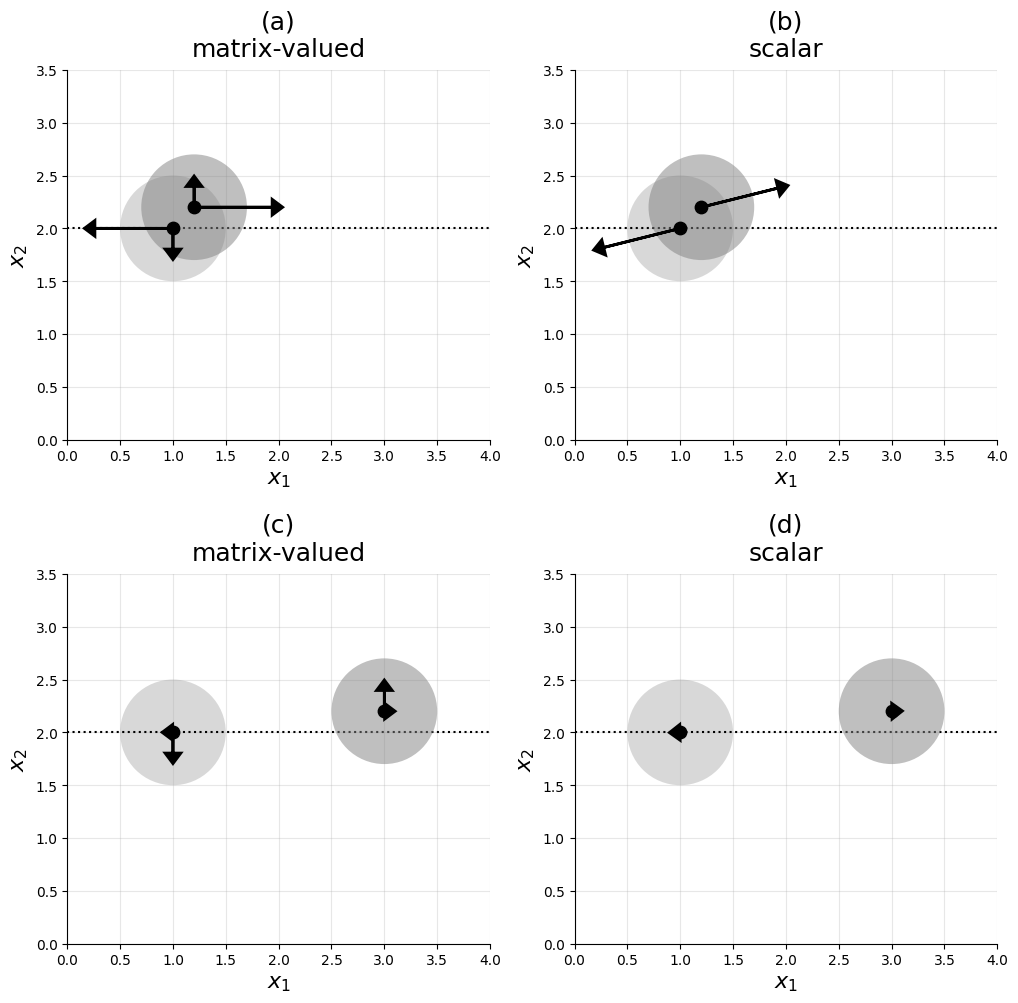

In [4]:
# Set up the figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
arrows_a = gradient_matrix_ab.numpy()
arrows_b = gradient_scalar_ab.numpy()
arrows_c = gradient_matrix_cd.numpy()
arrows_d = gradient_scalar_cd.numpy()

# Plot (a) - matrix-valued
plot_gradient_and_arrow_pff(axes[0, 0], x_ab, z_ab, arrows_a, '(a)\nmatrix-valued', is_matrix_valued=True)

# Plot (b) - scalar
plot_gradient_and_arrow_pff(axes[0, 1], x_ab, z_ab, arrows_b, '(b)\nscalar', is_matrix_valued=False)

# Plot (c) - matrix-valued
plot_gradient_and_arrow_pff(axes[1, 0], x_cd, z_cd, arrows_c, '(c)\nmatrix-valued', is_matrix_valued=True)

# Plot (d) - scalar
plot_gradient_and_arrow_pff(axes[1, 1], x_cd, z_cd, arrows_d, '(d)\nscalar', is_matrix_valued=False)


---

# Part 2: High-Dimensional Lorenz 96 Experiment

## Replicating Figure 3 from the Paper

Now we'll demonstrate the collapse phenomenon in a **100-dimensional Lorenz 96 system**.


In [5]:
# Setup L96 experiment (100-dimensional)

print("\n" + "="*70)
print("EXPERIMENT SETUP: 100-Dimensional Lorenz 96 System")
print("="*70)

# System parameters
dim = 100               # State dimension
F = 8.0                 # Forcing parameter
dt = 0.01               # Time step

# Time parameters
warm_nt = 1000          # Warmup time steps
nt = 21                 # Integration time 
obs_interval = 20       # Observe every 20 time steps

# Observation parameters
dim_interval = 4        # Observe every 4th variable
obs_err = 0.5           # Observation error SD
ny_obs = dim // dim_interval

# Ensemble parameters
np_particles = 20       # Number of particles
Q = 2 * tf.eye(dim, dtype=tf.float32)  # Initial perturbation covariance
R = obs_err**2 * tf.eye(ny_obs, dtype=tf.float32)  # Obs error covariance

# PFF parameters
alpha = 1.0 / np_particles
inflation_fac = 1.25
r_influ = 4
max_pseudo_step = 150
eps_init = 5e-2

print(f"\nState dimension: {dim}")
print(f"Observations: {ny_obs} out of {dim} variables ({ny_obs/dim*100:.0f}%)")
print(f"Observation pattern: Every {dim_interval}th variable")
print(f"Number of particles: {np_particles}")
print(f"\nObservation times: t = {[obs_interval * (i+1) for i in range(nt//obs_interval)]}")
print("\nWe will focus on the FIRST assimilation at t=20")
print("="*70)


EXPERIMENT SETUP: 100-Dimensional Lorenz 96 System

State dimension: 100
Observations: 25 out of 100 variables (25%)
Observation pattern: Every 4th variable
Number of particles: 20

Observation times: t = [20]

We will focus on the FIRST assimilation at t=20


In [6]:
# Generate truth and observations
Xt = generate_L96_trajectory(dim, warm_nt, nt, dt, F, L96_RK4)
y_obs, obs_indices, dim_indices = generate_observations(
    Xt, nt, warm_nt, obs_interval, dim_interval, R, dim
)
X_initial = generate_initial_ensemble(Xt, warm_nt, dim, np_particles, nt, Q)

X_list = [X_initial[:, :, i] for i in range(nt)]
X_list_for_matrix = [tf.identity(x) for x in X_list]
X_list_for_scalar= [tf.identity(x) for x in X_list]

print(f"\nTruth trajectory shape: {Xt.shape}")
print(f"Observations shape: {y_obs.shape}")
print(f"Number of observation times: {len(obs_indices)}")
print("\n✓ Truth and observations generated!")
print(f"Initial ensemble shape: {X_initial.shape}")
print(f"  → (dim={X_initial.shape[0]}, n_particles={X_initial.shape[1]}, nt={X_initial.shape[2]})")
print("\n✓ Initial ensemble prepared!")

Integrating L96 model...
  Step 200/1021
  Step 400/1021
  Step 600/1021
  Step 800/1021
  Step 1000/1021
Initial ensemble generated with 20 particles

Truth trajectory shape: (100, 1021)
Observations shape: (25, 1)
Number of observation times: 1

✓ Truth and observations generated!
Initial ensemble shape: (100, 20, 21)
  → (dim=100, n_particles=20, nt=21)

✓ Initial ensemble prepared!


In [7]:
# Initialize PFF with matrix-valued kernel

print("\n" + "="*70)
print("Initializing PFF with MATRIX-VALUED kernel")
print("="*70)

pff_matrix = ParticleFlowFilter(
    dim=dim,
    np_particles=np_particles,
    nt=nt,
    obs_interval=obs_interval,
    dim_interval=dim_interval,
    total_obs=nt // obs_interval,
    nx=dim,
    R=R,
    alpha=alpha,
    max_pseudo_step=max_pseudo_step,
    eps_init=eps_init,
    inflation_fac=inflation_fac,
    r_influ=r_influ,
    generate_Hx_si=generate_Hx_si,
    H_linear_adjoint=H_linear_adjoint,
    kernel_type='matrix'  # Matrix-valued kernel
)

print("✓ PFF with matrix-valued kernel initialized!")


Initializing PFF with MATRIX-VALUED kernel
✓ PFF with matrix-valued kernel initialized!


In [8]:
# Initialize PFF with scalar kernel
print("\n" + "="*70)
print("Initializing PFF with SCALAR kernel")
print("="*70)

pff_scalar = ParticleFlowFilter(
    dim=dim,
    np_particles=np_particles,
    nt=nt,
    obs_interval=obs_interval,
    dim_interval=dim_interval,
    total_obs=nt // obs_interval,
    nx=dim,
    R=R,
    alpha=alpha,
    max_pseudo_step=max_pseudo_step,
    eps_init=eps_init,
    inflation_fac=inflation_fac,
    r_influ=r_influ,
    generate_Hx_si=generate_Hx_si,
    H_linear_adjoint=H_linear_adjoint,
    kernel_type='scalar'  # Scalar kernel
)

print("✓ PFF with scalar kernel initialized!")


Initializing PFF with SCALAR kernel
✓ PFF with scalar kernel initialized!


In [9]:
# Run PFF with matrix-valued kernel

print("\n" + "="*70)
print("RUNNING PFF WITH MATRIX-VALUED KERNEL")
print("="*70)

def model_step(X_current):
    """Wrapper for L96_RK4 model step."""
    return L96_RK4(X_current, dt, F=F)

X_list_matrix_updated = pff_matrix.run(
    X_list=X_list_for_matrix,
    y_obs=y_obs,
    model_step=model_step,
    t_start=0,
    verbose=True
)

print("\n✓ PFF with matrix-valued kernel completed!")


RUNNING PFF WITH MATRIX-VALUED KERNEL

Starting Particle Flow Filter Data Assimilation

  Time t=20, Observation 1/1
    Iteration s=0, norm=100.00%, eps=5.00e-02
    Iteration s=10, norm=28.21%, eps=7.50e-02
    [Note] eps changed to 7.50e-02, redo iteration
    [Note] eps changed to 5.00e-02, redo iteration
    [Note] eps changed to 3.33e-02, redo iteration
    Iteration s=20, norm=11.78%, eps=3.33e-02
    Iteration s=30, norm=8.51%, eps=5.00e-02
    Iteration s=40, norm=5.32%, eps=1.13e-01
    Convergence reached at iteration 43
  PFF completed in 43 iterations

PFF Data Assimilation Complete!

✓ PFF with matrix-valued kernel completed!


In [10]:
# Run PFF with scalar kernel

print("\n" + "="*70)
print("RUNNING PFF WITH SCALAR KERNEL")
print("="*70)

X_list_scalar_updated = pff_scalar.run(
    X_list=X_list_for_scalar,
    y_obs=y_obs,
    model_step=model_step,
    t_start=0,
    verbose=True
)

print("\n✓ PFF with scalar kernel completed!")


RUNNING PFF WITH SCALAR KERNEL

Starting Particle Flow Filter Data Assimilation

  Time t=20, Observation 1/1
    Iteration s=0, norm=100.00%, eps=5.00e-02
    Iteration s=10, norm=65.96%, eps=7.50e-02
    Iteration s=20, norm=40.95%, eps=1.13e-01
    Iteration s=30, norm=24.67%, eps=1.69e-01
    Iteration s=40, norm=14.42%, eps=3.80e-01
    Iteration s=50, norm=8.76%, eps=5.70e-01
    Iteration s=60, norm=6.00%, eps=8.54e-01
    Convergence reached at iteration 66
  PFF completed in 66 iterations

PFF Data Assimilation Complete!

✓ PFF with scalar kernel completed!


---

## Visualizing Marginal Distributions (Figure 3)

Now we'll create the key figure showing:
- **Prior particles** (black circles): Before assimilation
- **Posterior particles** (red circles): After assimilation

We'll examine:
- $x_{19}$: **Unobserved** variable (index 18 in 0-based indexing)
- $x_{20}$: **Observed** variable (index 19 in 0-based indexing)

In [11]:
# Extract prior and posterior particles for visualization

# Variable indices (0-based indexing)
idx_unobs = 18  # x_19 (unobserved)
idx_obs = 19    # x_20 (observed)

# Prior particles (before first assimilation)
prior_particles_matrix = pff_matrix.prior_particles[0]  # First (and only) observation time
prior_particles_scalar = pff_scalar.prior_particles[0]

# Posterior particles (after first assimilation)
posterior_particles_matrix = pff_matrix.posterior_particles[0]
posterior_particles_scalar = pff_scalar.posterior_particles[0]

# Truth values at t=20
truth_t20 = Xt[:, warm_nt + obs_interval]

print(f"\nVariables to visualize:")
print(f"  x_19 (index {idx_unobs}): UNOBSERVED")
print(f"  x_20 (index {idx_obs}): OBSERVED")
print(f"\nPrior particles shape: {prior_particles_matrix.shape}")
print(f"Posterior particles shape: {posterior_particles_matrix.shape}")
print(f"\nTruth values at t=20:")
print(f"  x_19 = {truth_t20[idx_unobs]:.4f}")
print(f"  x_20 = {truth_t20[idx_obs]:.4f}")


Variables to visualize:
  x_19 (index 18): UNOBSERVED
  x_20 (index 19): OBSERVED

Prior particles shape: (100, 20)
Posterior particles shape: (100, 20)

Truth values at t=20:
  x_19 = 4.3580
  x_20 = -0.3562


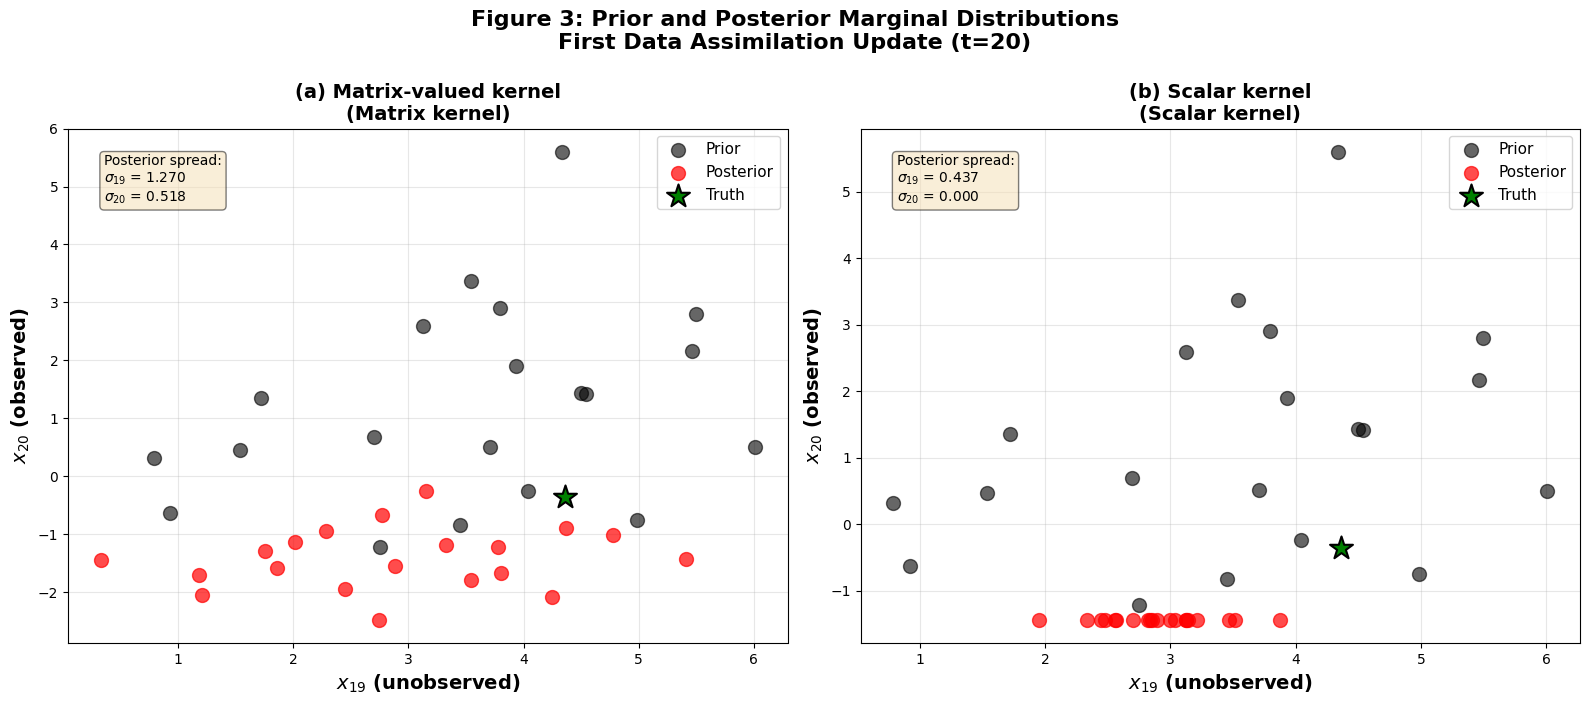

In [12]:
# Create Figure 3: Marginal distributions comparison

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Plot both kernels
plot_marginal_distribution(axes[0], idx_unobs, idx_obs, prior_particles_matrix, posterior_particles_matrix,
                            truth_t20, 
                           '(a) Matrix-valued kernel', 'Matrix kernel')

plot_marginal_distribution(axes[1], idx_unobs, idx_obs, prior_particles_scalar, posterior_particles_scalar,
                            truth_t20,
                           '(b) Scalar kernel', 'Scalar kernel')

plt.suptitle('Figure 3: Prior and Posterior Marginal Distributions\n' + 
             'First Data Assimilation Update (t=20)',
             fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()
